## Autoencoder
### Descripción
Este proyecto trata sobre como usaremos el Autoenconder con redes convolutivas para la superresolución de imagenes, donde entrenaremos el modelo con imagenes de baja resolución (7x7 y 14x14) y lo usaremos para reconstruir imagenes de alta resolución (28x28), que es el tamaño original de las imagenes del dataset MNIST.

También se puede usar para la eliminación de ruido en imágenes, ya que al reconstruir la imagen se eliminan los pixeles que no son necesarios. Usaremos el encoder para reducir la dimensionalidad de la imagen y el decoder para reconstruir la imagen sin ruido.

### Dataset
El dataset que usaremos será el MNIST, que es un dataset de imágenes de dígitos escritos a mano. Este dataset contiene 60,000 imágenes de entrenamiento y 10,000 imágenes de prueba. Las imágenes son de 28x28 pixeles.

### Eliminación de ruido en imágenes (denoising)
Para la eliminación de ruido en imágenes, se añadirá ruido a las imágenes del dataset y se entrenará el autoencoder para que reconstruya la imagen sin ruido.
#### Código
##### Librerías
- torch : Librería de PyTorch
- torch.nn : Módulo de PyTorch para construir redes neuronales
- torch.optim : Módulo de PyTorch para optimización
- torch.nn.functional : Módulo de PyTorch con funciones de activación
- torchvision : Librería de PyTorch para visión artificial
- matplotlib : Librería para graficar


##### Carga de datos
Primero cargamos las librerías necesarias y definimos las transformaciones que se le harán a las imágenes del dataset. Luego cargamos el dataset de entrenamiento y validación.

In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
    ])

transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)

mnist_data_valid = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

data_loader_valid = torch.utils.data.DataLoader(dataset=mnist_data_valid,
                                          batch_size=64,
                                          shuffle=True)    

##### Modelo
Defininiremos el autoencoder con redes convolutivas. El autoencoder consta de dos partes: el encoder y el decoder. El encoder reduce la dimensionalidad de la imagen y el decoder reconstruye la imagen original sin ruido.

Utilizaremos 3 capas convolutivas en el encoder y 3 capas convolutivas en el decoder. La función de activación que usaremos será ReLU. La última capa del decoder tendrá una función de activación sigmoide para que la salida esté entre 0 y 1.

In [81]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

##### Función para generar ruido
Definimos una función para añadir ruido a las imágenes del dataset.

In [82]:
def agregar_ruido(imagenes, nivel_ruido=0.5):
    ruido = torch.randn_like(imagenes) * nivel_ruido
    imagenes_ruido = imagenes + ruido
    imagenes_ruido = torch.clip(imagenes_ruido, 0., 1.)
    return imagenes_ruido

##### Entrenamiento
Entrenaremos el autoencoder con el dataset de entrenamiento. Calcularemos el error de reconstrucción de la imagen y usaremos el error para optimizar el modelo. Usaremos el modelo anterior para eliminar el ruido de las imágenes del dataset de validación.

Como criterio de error usaremos el error cuadrático medio (MSE) y como optimizador usaremos Adam.

In [83]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

num_epochs = 10
outputs = []

for epoch in range(num_epochs):
    for (img, _) in data_loader:
        img_ruido = agregar_ruido(img)  # Añadir ruido a las imágenes
        #img_noisy = img_noisy.reshape(-1, 28 * 28)  # Ajustar dimensiones para Autoencoder
        #img = img.reshape(-1, 28 * 28)
        
        recon = model(img_ruido)  # Reconstrucción
        loss = criterion(recon, img)  # Comparar con las imágenes originales
        #probar el loss con la imagen con ruida, o con la normal => compararla con la del ruido, y con la normal
        #loss = criterion(recon,img_noisy) => usamos el otro, porque los pesos se tienen que ir ajustando con la imagen buena y no la de con ruido
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch: {epoch + 1}, Loss: {loss.item():.4f}')
    outputs.append((epoch, img_ruido, img, recon))


Epoch: 1, Loss: 0.0193
Epoch: 2, Loss: 0.0158
Epoch: 3, Loss: 0.0134
Epoch: 4, Loss: 0.0120
Epoch: 5, Loss: 0.0116
Epoch: 6, Loss: 0.0116
Epoch: 7, Loss: 0.0121
Epoch: 8, Loss: 0.0118
Epoch: 9, Loss: 0.0109
Epoch: 10, Loss: 0.0120


##### Visualización de resultados
Visualizaremos las imágenes originales, las imágenes con ruido y las imágenes reconstruidas por el autoencoder.

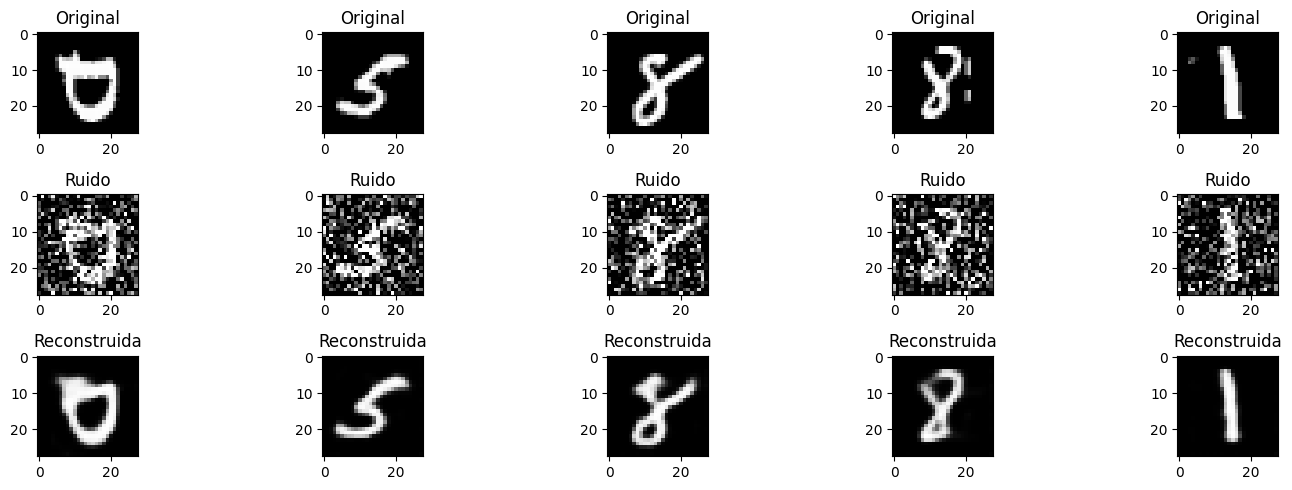

In [84]:
plt.figure(figsize=(15, 5))
plt.gray()
for i in range(5):
    idx = i + 1
    img_noisy = outputs[-1][1][i].reshape(28, 28).detach().numpy()
    img_orig = outputs[-1][2][i].reshape(28, 28).detach().numpy()
    img_recon = outputs[-1][3][i].reshape(28, 28).detach().numpy()
    
    # Imagen original
    plt.subplot(3, 5, idx)
    plt.title("Original")
    plt.imshow(img_orig)
    
    # Imagen con ruido
    plt.subplot(3, 5, idx + 5)
    plt.title("Ruido")
    plt.imshow(img_noisy)
    
    # Imagen reconstruida
    plt.subplot(3, 5, idx + 10)
    plt.title("Reconstruida")
    plt.imshow(img_recon)

plt.tight_layout()
plt.show()

### Superresolución de imágenes
Para la superresolución de imágenes, se reducirá la resolución de las imágenes del dataset y se entrenará el autoencoder para que reconstruya la imagen a tamaño 28x28, que es el tamaño original de las imágenes del dataset.

#### Código
##### Librerías
- torch : Librería de PyTorch
- torch.nn : Módulo de PyTorch para construir redes neuronales
- torchvision : Librería de PyTorch para visión artificial
- torch.utils.data : Módulo de PyTorch para cargar datos
- matplotlib : Librería para graficar

##### Carga de datos
En esta celda se configuran los datasets y DataLoaders necesarios para entrenar y evaluar el autoencoder, garantizando la correcta alineación entre las imágenes originales y las reducidas. Las transformaciones aplicadas a las imágenes originales de 28x28 normalizan sus valores al rango [-1, 1], preparándolas para ser utilizadas como referencia en el cálculo de la pérdida. Por otro lado, las imágenes reducidas se transforman y redimensionan a resoluciones de 7x7 y 14x14, manteniendo el formato compatible con las entradas de los autoencoders.

La combinación de los datasets originales y reducidos en un solo DataLoader asegura que cada imagen reducida se alinee correctamente con su correspondiente imagen original. Esto se realiza mediante la función zip, que crea pares de imágenes (original, reducida) para cada muestra del conjunto de datos. De esta manera, los modelos pueden reconstruir las imágenes originales a partir de las reducidas y comparar directamente la reconstrucción con la referencia original. Este enfoque es esencial para garantizar la coherencia durante el entrenamiento y la evaluación del modelo.

In [92]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformación para imágenes originales (28x28)
transform_original = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalización a [-1, 1]
])

# Transformación para imágenes reducidas a 7x7
transform_7x7 = transforms.Compose([
    transforms.Resize((7, 7)),  # Reducir resolución a 7x7
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Transformación para imágenes reducidas a 14x14
transform_14x14 = transforms.Compose([
    transforms.Resize((14, 14)),  # Reducir resolución a 14x14
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Dataset para imágenes originales
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform_original)
mnist_data_valid = datasets.MNIST(root='./data', train=False, download=True, transform=transform_original)

# Dataset para imágenes reducidas
mnist_data_7x7 = datasets.MNIST(root='./data', train=True, download=True, transform=transform_7x7)
mnist_data_valid_7x7 = datasets.MNIST(root='./data', train=False, download=True, transform=transform_7x7)

mnist_data_14x14 = datasets.MNIST(root='./data', train=True, download=True, transform=transform_14x14)
mnist_data_valid_14x14 = datasets.MNIST(root='./data', train=False, download=True, transform=transform_14x14)


# DataLoader combinados para entrenamiento (train) y validación (valid)
combined_loader_train_7x7 = DataLoader(
    dataset=list(zip(mnist_data, mnist_data_7x7)),
    batch_size=64,
    shuffle=True
)

combined_loader_valid_7x7 = DataLoader(
    dataset=list(zip(mnist_data_valid, mnist_data_valid_7x7)),
    batch_size=64,
    shuffle=False
)

combined_loader_train_14x14 = DataLoader(
    dataset=list(zip(mnist_data, mnist_data_14x14)),
    batch_size=64,
    shuffle=True
)

combined_loader_valid_14x14 = DataLoader(
    dataset=list(zip(mnist_data_valid, mnist_data_valid_14x14)),
    batch_size=64,
    shuffle=False
)


print("Carga de datos completa:")
print(f"Original (28x28): {len(DataLoader(dataset=mnist_data_valid, batch_size=64, shuffle=False))} batches")
print(f"Reducción (7x7): {len(DataLoader(dataset=mnist_data_valid_7x7, batch_size=64, shuffle=False))} batches")
print(f"Reducción (14x14): {len(DataLoader(dataset=mnist_data_valid_14x14, batch_size=64, shuffle=False))} batches")


Carga de datos completa:
Original (28x28): 157 batches
Reducción (7x7): 157 batches
Reducción (14x14): 157 batches


##### Modelo para resolucion 7x7
El autoencoder que construimos reduce y reconstruye imágenes cambiando resolución y canales. El encoder aumenta los canales de 1 a 32 para extraer características mientras mantiene la resolución a 7x7.

El decoder invierte este proceso, pasando de 32 a 1 canal y aumentando la resolución a 28x28 mediante capas transpuestas convolutivas, logrando reconstrucciones similares a las imágenes originales desde las resoluciones reducidas de 7x7.

Aquí esta la gracia de lo que es la superresolución, ya que el autoencoder aprende a reconstruir imágenes de baja resolución a la resolución original.

In [93]:
import torch.nn as nn

class Autoencoder7x7(nn.Module):
    def __init__(self):
        super(Autoencoder7x7, self).__init__()
        
        # Encoder para 7x7
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # -> N, 16, 7, 7
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # -> N, 32, 7, 7
            nn.ReLU(),
        )
        
        # Decoder para 28x28
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> N, 16, 14, 14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> N, 1, 28, 28
            nn.Tanh()  # Salida normalizada entre [-1, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


##### Modelo para resolucion 14x14
El modelo autoencoder que usamos es para imágenes de 14x14 tiene un encoder sencillo que incrementa los canales de 1 a 16, manteniendo la resolución constante. Esto permite extraer características importantes de las imágenes sin reducir su tamaño.

El decoder utiliza convoluciones transpuestas para reducir los canales de 16 a 1 mientras aumenta la resolución a 28x28. Este diseño logra reconstruir las imágenes originales a partir de las entradas de menor resolución de manera eficiente.

In [94]:
class Autoencoder14x14(nn.Module):
    def __init__(self):
        super(Autoencoder14x14, self).__init__()
        
        # Encoder para 14x14
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # -> N, 16, 14, 14
            nn.ReLU(),
        )
        
        # Decoder para 28x28
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> N, 1, 28, 28
            nn.Tanh()  # Salida normalizada entre [-1, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


##### Entrenamiento
La función de entrenamiento se encarga de optimizar el autoencoder para reconstruir imágenes originales a partir de imágenes reducidas. Utiliza el Mean Squared Error (MSE) como función de pérdida para medir la diferencia entre las imágenes reconstruidas y las originales. En cada época, los datos se envían al dispositivo (GPU), se realiza el paso de forward para obtener las reconstrucciones, y se actualizan los pesos del modelo mediante el optimizador Adam. Finalmente, se imprime la pérdida promedio por época para monitorear el progreso del entrenamiento.

In [95]:
def train_autoencoder(model, combined_loader_train, epochs=5):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for (original, reduced) in combined_loader_train:
            original = original[0].to(device)
            reduced = reduced[0].to(device)

            optimizer.zero_grad()
            _, reconstructed = model(reduced)
            loss = criterion(reconstructed, original)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(combined_loader_train):.4f}")

    print("Entrenamiento completado.")


##### Visualización
La función de visualización muestra los resultados del autoencoder al reconstruir imágenes originales a partir de entradas reducidas. En modo de evaluación (eval), se procesan los datos sin calcular gradientes. Para cada batch, se extraen las imágenes originales, reducidas y reconstruidas, trasladándolas a la GPU para visualización. Estas imágenes se presentan en una cuadrícula de tres filas: la primera fila muestra las imágenes originales, la segunda fila las imágenes reducidas y la tercera fila las reconstrucciones generadas por el modelo. Esto permite comparar visualmente la calidad de las reconstrucciones y evaluar el rendimiento del autoencoder.

In [96]:
def visualize_results(model, combined_loader_valid):
    model.eval()
    with torch.no_grad():
        for (original, reduced) in combined_loader_valid:
            original = original[0].to(device)
            reduced = reduced[0].to(device)

            _, reconstructed = model(reduced)

            original = original.cpu().numpy()
            reduced = reduced.cpu().numpy()
            reconstructed = reconstructed.cpu().numpy()

            fig, axes = plt.subplots(3, 5, figsize=(10, 6))
            for i in range(5):
                axes[0, i].imshow(original[i].squeeze(), cmap='gray')
                axes[0, i].set_title("Original")
                axes[0, i].axis('off')

                axes[1, i].imshow(reduced[i].squeeze(), cmap='gray')
                axes[1, i].set_title("Reducida")
                axes[1, i].axis('off')

                axes[2, i].imshow(reconstructed[i].squeeze(), cmap='gray')
                axes[2, i].set_title("Reconstruida")
                axes[2, i].axis('off')

            plt.tight_layout()
            plt.show()
            break


#### Resultados
Podemos comprobar que el uso de los autoencoders para reconstrucción de imagenes es bastante efectivo, ya que logra reconstruir imagenes de baja resolución como hacemos en las pruebas con imagenes en 7x7 y 14x14 a imagenes de 28x28, que es el tamaño original de las imagenes del dataset MNIST.

**Resultados para la reducción al 7x7:**

Trabajando con el modelo 7x7...
Epoch [1/5], Loss: 0.1200
Epoch [2/5], Loss: 0.0524
Epoch [3/5], Loss: 0.0442
Epoch [4/5], Loss: 0.0403
Epoch [5/5], Loss: 0.0378
Entrenamiento completado.


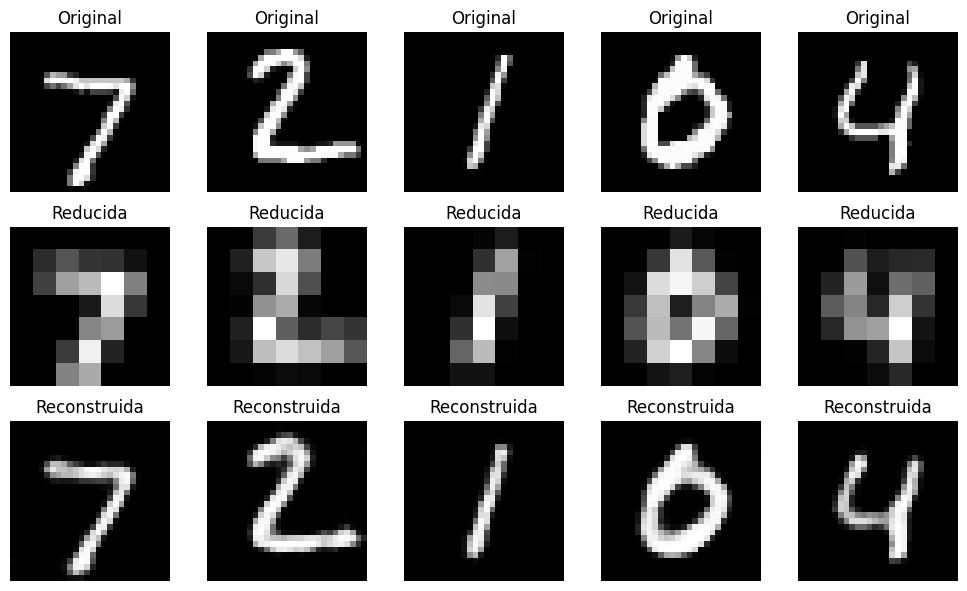

In [97]:
print("Trabajando con el modelo 7x7...")

model_7x7 = Autoencoder7x7().to(device)

# Entrenamiento con datos combinados de entrenamiento
train_autoencoder(
    model=model_7x7,
    combined_loader_train=combined_loader_train_7x7,
    epochs=5
)

# Visualización con datos combinados de validación
visualize_results(
    model=model_7x7,
    combined_loader_valid=combined_loader_valid_7x7
)


**Resultados para la reducción al 14x14:**

Trabajando con el modelo 14x14...
Epoch [1/5], Loss: 0.0668
Epoch [2/5], Loss: 0.0179
Epoch [3/5], Loss: 0.0155
Epoch [4/5], Loss: 0.0143
Epoch [5/5], Loss: 0.0134
Entrenamiento completado.


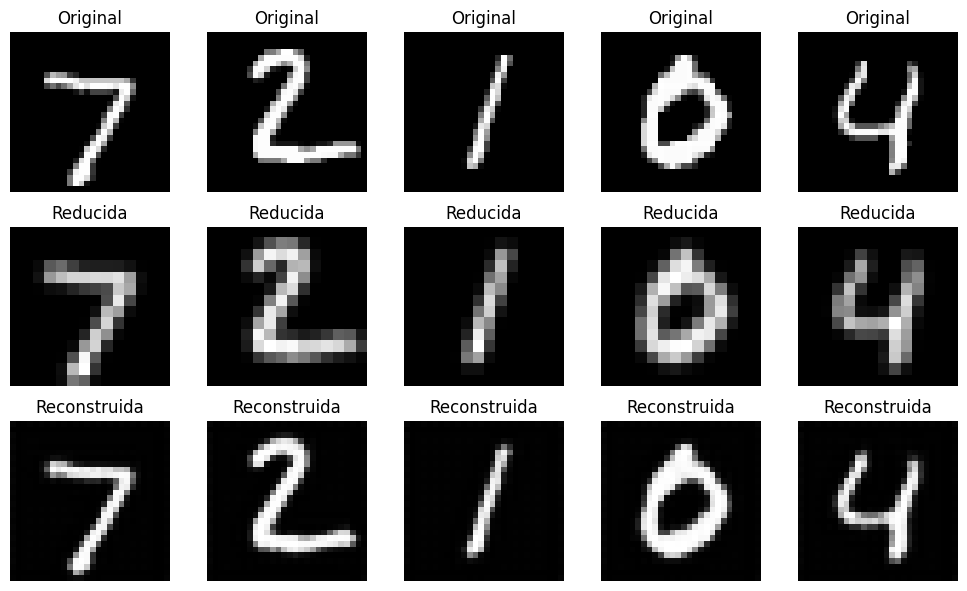

In [98]:
print("Trabajando con el modelo 14x14...")

model_14x14 = Autoencoder14x14().to(device)

# Entrenamiento con datos combinados de entrenamiento
train_autoencoder(
    model=model_14x14,
    combined_loader_train=combined_loader_train_14x14,
    epochs=5
)

# Visualización con datos combinados de validación
visualize_results(
    model=model_14x14,
    combined_loader_valid=combined_loader_valid_14x14
)
